# Q1: Tri-VAE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
shutil.copytree('/content/data', '/content/drive/My Drive/hw6')

In [1]:
import kagglehub
import shutil

## Dataset

### downloading datasets

In [2]:
try:
    path = kagglehub.dataset_download("haonanzhou1/ixit2-slices")
    shutil.copytree(path, './data/ixi')
except:
    print("folder already exists!")
shutil.rmtree(path)

100%|██████████| 781M/781M [00:35<00:00, 23.1MB/s]

Extracting files...


In [3]:
try:
    path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")
except:
    print("folder already exists!")

100%|██████████| 4.16G/4.16G [03:09<00:00, 23.6MB/s]

Extracting files...


In [4]:
import os
shutil.copytree(os.path.join(path,"BraTS2020_TrainingData"), './data/brats_training/')
shutil.rmtree(path)

### showing a few instances

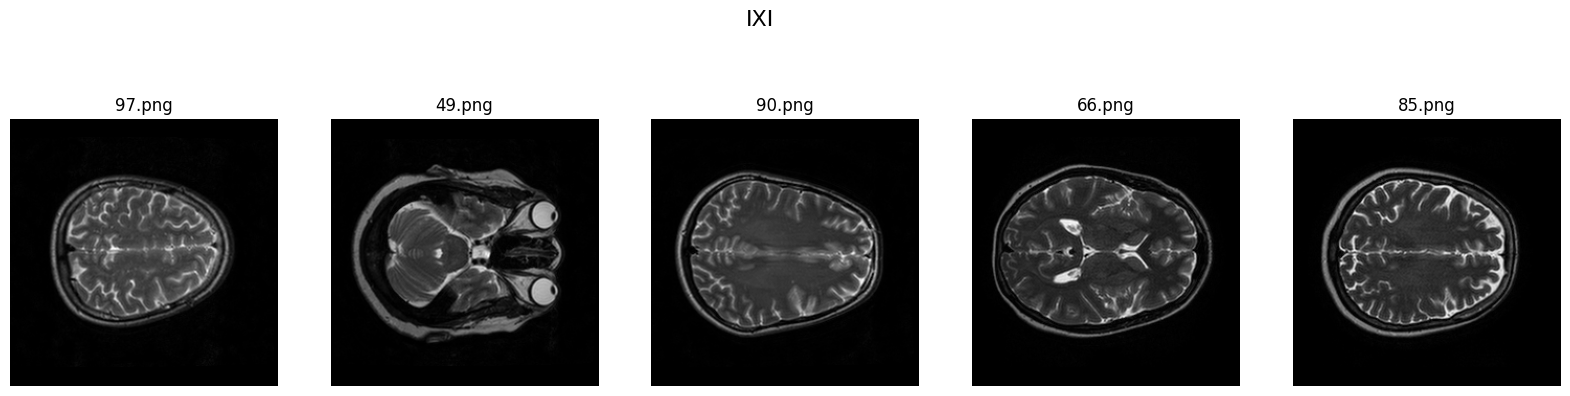

In [5]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

dataset_path = '/content/data/ixi/image slice-T2'

image_folders = random.sample(os.listdir(dataset_path), 5)

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('IXI', fontsize=16)

for i, image_folder in enumerate(image_folders):
  image_name = random.sample(os.listdir(os.path.join(dataset_path, image_folder)), 1)[0]
  image_path = os.path.join(dataset_path, image_folder, image_name)
  image = Image.open(image_path)
  axes[i].imshow(image, cmap='gray')
  axes[i].set_title(image_name)
  axes[i].axis('off')

plt.show()

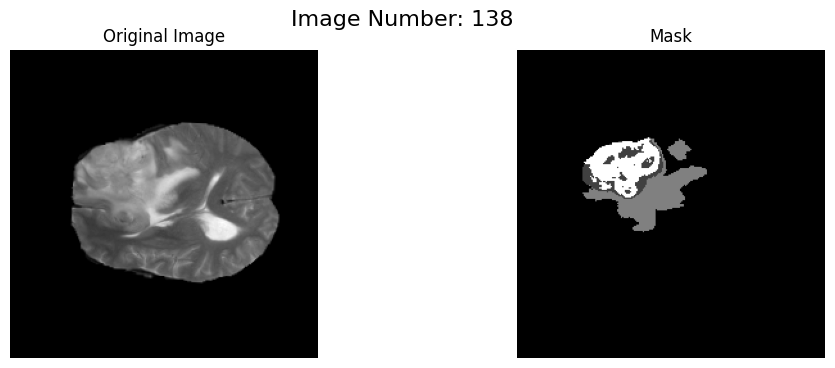

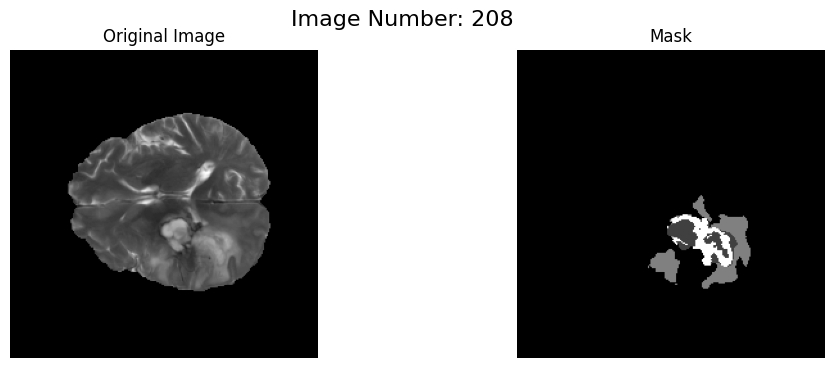

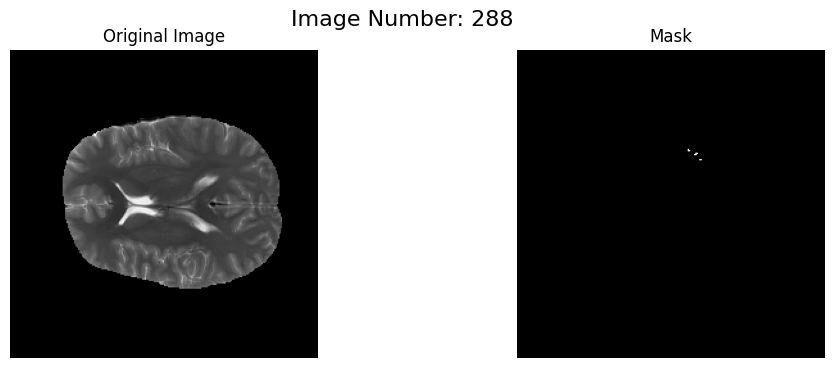

In [6]:
import matplotlib.pyplot as plt
import nibabel as nib
import random

def show_brats_data(image_addr, image_num):
  image = nib.load(image_addr)
  mask = nib.load(image_addr.replace('_t2', '_seg'))

  fig, axes = plt.subplots(1, 2, figsize=(12, 4))
  fig.suptitle(f'Image Number: {image_num}', fontsize=16)

  axes[0].imshow(image.get_fdata()[:, :, image.shape[2] // 2], cmap='gray')
  axes[0].set_title('Original Image')
  axes[0].axis('off')

  axes[1].imshow(mask.get_fdata()[:, :, mask.shape[2] // 2], cmap='gray')
  axes[1].set_title('Mask')
  axes[1].axis('off')

  plt.show()

brats_folder='/content/data/brats_training/MICCAI_BraTS2020_TrainingData'
img_count=len([item for item in os.listdir(brats_folder) if os.path.isdir(os.path.join(brats_folder, item))])

for i in range(3):
  img_num=random.randint(0, img_count-1)
  img_addr=f'BraTS20_Training_{img_num:03}/BraTS20_Training_{img_num:03}_t2.nii'
  show_brats_data(os.path.join(brats_folder, img_addr), img_num)

### making datasets

In [7]:
from torch.utils.data import Dataset

class IXIDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img = self.df.iloc[idx]['image']

    if self.transform:
      img = self.transform(img)
    return img

class BratsDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img = self.df.iloc[idx]['image']
    mask = self.df.iloc[idx]['mask']

    if self.transform:
      mask = self.transform(mask)
      img = self.transform(img)
    return img, mask

In [8]:
import pandas as pd
import os

dataset_path = '/content/data/ixi/image slice-T2'

image_folders = os.listdir(dataset_path)
image_data = []

for i, image_folder in enumerate(image_folders):
  image_names = os.listdir(os.path.join(dataset_path, image_folder))
  for image_name in image_names:
    image_path = os.path.join(dataset_path, image_folder, image_name)
    image = Image.open(image_path)

    image_data.append({'image_path': image_path, 'image': image})
ixi_df = pd.DataFrame(image_data)

In [9]:
len(ixi_df)

28850

In [10]:
import os
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image

brats_folder='/content/data/brats_training/MICCAI_BraTS2020_TrainingData'
brats_folders = [item for item in os.listdir(brats_folder) if os.path.isdir(os.path.join(brats_folder, item))]

brats_data = []

for i, brats_folder_name in enumerate(brats_folders):

  image_addr = os.path.join(brats_folder, brats_folder_name, f'{brats_folder_name}_t2.nii')
  mask_addr = image_addr.replace('_t2', '_seg')
  image = nib.load(image_addr)
  image = image.get_fdata()[:, :, image.shape[2] // 2]

  try:
    mask = nib.load(mask_addr)
  except:
    continue

  mask =  mask.get_fdata()[:, :, mask.shape[2] // 2]

  image = Image.fromarray(image)
  image = np.array(image.resize((256,256)))
  mask = Image.fromarray(mask)
  mask = np.array(mask.resize((256,256)))

  brats_data.append({'image_path': image_addr, 'mask_path': mask_addr, 'image': image, 'mask':mask})

brats_df = pd.DataFrame(brats_data)

In [11]:
len(brats_data)

368

In [12]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256))
])

ixi_dataset = IXIDataset(ixi_df, transform=transform)
brats_dataset = BratsDataset(brats_df, transform=transform)

In [13]:
small_ixi=IXIDataset(ixi_df[:100], transform=transform)

## VAE

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    self.fc1 = nn.Linear(256*256, 1024)
    self.fc21 = nn.Linear(1024, 20)  # Latent space
    self.fc22 = nn.Linear(1024, 20)
    self.fc3 = nn.Linear(20, 1024)
    self.fc4 = nn.Linear(1024, 256*256)

  def encode(self, x):
    h1 = F.relu(self.fc1(x))
    return self.fc21(h1), self.fc22(h1)

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def decode(self, z):
    h3 = F.relu(self.fc3(z))
    return torch.sigmoid(self.fc4(h3))

  def forward(self, x):
    mu, logvar = self.encode(x.view(-1, 256*256))
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [16]:
transform = transforms.ToTensor()
train_loader = DataLoader(small_ixi, batch_size=4, shuffle=True)

vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

def train(epoch):
  vae.train()
  train_loss = 0
  for batch_idx, data in enumerate(train_loader):
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mu, logvar = vae(data)
    loss = F.binary_cross_entropy(recon_batch, data.view(-1, 256*256), reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = loss + kld
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
  print(f'Epoch: {epoch} Loss: {train_loss / len(train_loader.dataset):.4f}')


In [17]:
for epoch in range(20):
  train(epoch)

Epoch: 0 Loss: 22533.0807
Epoch: 1 Loss: 17460.2314
Epoch: 2 Loss: 16887.3438
Epoch: 3 Loss: 16511.1891
Epoch: 4 Loss: 16204.4070
Epoch: 5 Loss: 16027.5077
Epoch: 6 Loss: 15821.1620
Epoch: 7 Loss: 15722.3431
Epoch: 8 Loss: 15648.1502
Epoch: 9 Loss: 15647.3823
Epoch: 10 Loss: 15573.5919
Epoch: 11 Loss: 15513.0111
Epoch: 12 Loss: 15453.0114
Epoch: 13 Loss: 15492.6843
Epoch: 14 Loss: 15480.4354
Epoch: 15 Loss: 15491.8087
Epoch: 16 Loss: 15461.2500
Epoch: 17 Loss: 15525.4236
Epoch: 18 Loss: 15445.1336
Epoch: 19 Loss: 15401.4036


In [59]:
test_loader=DataLoader(brats_dataset, batch_size=4, shuffle=True)

Avg Dice: 0.09974759421311319


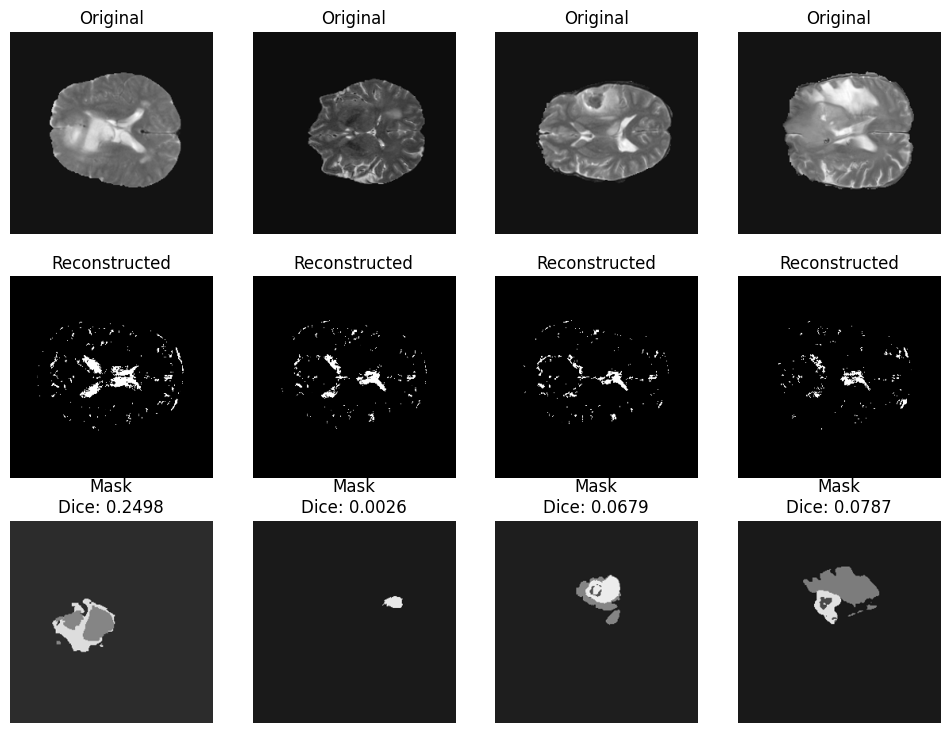

In [19]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

def dice_coefficient(pred, target):
    smooth = 1.0
    pred_flat = pred.view(-1).float()
    target_flat = target.view(-1).float()
    intersection = (pred_flat * target_flat).sum()
    return (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

vae.eval()
with torch.no_grad():
  for i, data in enumerate(test_loader):
    data, mask = data
    data = data.view(-1, 256*256)
    recon_batch, _, _ = vae(data.to(device))

    fig, axes = plt.subplots(3, data.size(0), figsize=(12, 9))
    dice_scores = []
    for j in range(data.size(0)):
      original_image = data[j].view(256, 256)
      reconstructed_image = recon_batch[j].view(256, 256)
      mask_image = mask[j].view(256, 256)
      dice_score = dice_coefficient(reconstructed_image.to(device), mask_image.to(device))
      dice_scores.append(dice_score.item())

      axes[0, j].imshow(original_image, cmap='gray')
      axes[0, j].set_title('Original')
      axes[0, j].axis('off')

      axes[1, j].imshow(reconstructed_image.cpu(), cmap='gray')
      axes[1, j].set_title('Reconstructed')
      axes[1, j].axis('off')

      axes[2, j].imshow(mask_image, cmap='gray')
      axes[2, j].set_title(f'Mask\nDice: {dice_score:.4f}')
      axes[2, j].axis('off')

    print(f"Avg Dice: {sum(dice_scores)/len(data)}")

    plt.show()
    break


## TriVAE

In [169]:
pip install pytorch-msssim

In [232]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_channels=1, latent_dim=128):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(128 * 32 * 32, latent_dim)
        self.fc_logvar = nn.Linear(128 * 32 * 32, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim=128, output_channels=1):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1)

        self.coarse_conv = nn.Conv2d(32, 1, 1)

        self.deconv4 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.deconv5 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1)
        self.deconv6 = nn.ConvTranspose2d(8, output_channels, 3, stride=2, padding=1, output_padding=1)

    def forward(self, z):
        z = F.relu(self.fc(z)).view(-1, 128, 4, 4)
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.relu(self.deconv3(z))

        x_coarse = torch.sigmoid(self.coarse_conv(z))

        z = F.relu(self.deconv4(z))
        z = F.relu(self.deconv5(z))
        x_hat = torch.sigmoid(self.deconv6(z))

        return x_hat, x_coarse

class GatedCrossSkip(nn.Module):
    def __init__(self, channels, reduction_ratio=4):
        super(GatedCrossSkip, self).__init__()
        self.encoder_fc = nn.Linear(channels, channels // reduction_ratio)
        self.decoder_fc = nn.Linear(channels, channels // reduction_ratio)
        self.tanh = nn.Tanh()

    def forward(self, encoder_features, decoder_features):
        encoder_proj = self.encoder_fc(encoder_features)
        decoder_proj = self.decoder_fc(decoder_features)
        attention_map = F.cosine_similarity(encoder_proj, decoder_proj, dim=1, eps=1e-6)
        modulated_features = self.tanh(attention_map).unsqueeze(-1).unsqueeze(-1) * decoder_features
        return modulated_features

class TriVAE(nn.Module):
    def __init__(self, input_channels=1, latent_dim=128):
        super(TriVAE, self).__init__()
        self.encoder = Encoder(input_channels, latent_dim)
        self.decoder = Decoder(latent_dim, input_channels)
        self.gcs = GatedCrossSkip(latent_dim)

    def forward(self, x, encoder_features=None):
        mu, logvar = self.encoder(x)
        z = self.sample(mu, logvar)
        x_hat, x_coarse = self.decoder(z)
        return x_hat, x_coarse, mu, logvar

    @staticmethod
    def sample(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

Epoch: -1 Loss: 6.1041


In [426]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.nn import functional as F
from torch.optim import Adam
from skimage.metrics import structural_similarity as ssim
from pytorch_msssim import ssim

transform = transforms.ToTensor()
# train_loader = DataLoader(small_ixi, batch_size=4, shuffle=True)
ixi1000_dataset = IXIDataset(ixi_df[:100], transform=transform)
train_loader = DataLoader(ixi1000_dataset, batch_size=4, shuffle=True)

trivae = TriVAE(input_channels=1, latent_dim=256).to(device)

optimizer = Adam(trivae.parameters(), lr=1e-3)

def triplet_loss(anchor, positive, negative, alpha=1.0):
    pos_dist = F.pairwise_distance(anchor, positive, p=2)
    neg_dist = F.pairwise_distance(anchor, negative, p=2)
    loss = torch.clamp(pos_dist - neg_dist + alpha, min=0.0).mean()
    return loss


def train_trivae(epoch):
    trivae.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        anchor = data.to(device)
        positive = data.to(device)
        negative = data.to(device)
        noise = torch.randn_like(negative)
        negative += noise

        recon_anchor_full, recon_anchor_coarse, mu_anchor, logvar_anchor = trivae(anchor)
        recon_positive_full, recon_positive_coarse, mu_positive, logvar_positive = trivae(positive)
        recon_negative_full, recon_negative_coarse, mu_negative, logvar_negative = trivae(negative)

        negative_resized = transforms.Resize((recon_negative_coarse.shape[2], recon_negative_coarse.shape[3]))(negative)
        positive_resized = transforms.Resize((recon_positive_coarse.shape[2], recon_positive_coarse.shape[3]))(positive)
        anchor_resized = transforms.Resize((recon_anchor_coarse.shape[2], recon_anchor_coarse.shape[3]))(anchor)
        l1_neg_coarse = F.l1_loss(recon_negative_coarse, negative_resized)
        l1_neg_full = F.l1_loss(recon_negative_full, negative)
        l1_anc = F.l1_loss(recon_anchor_coarse, anchor_resized)
        l1_pos = F.l1_loss(recon_positive_coarse, positive_resized)
        l1_total= l1_neg_coarse + l1_neg_full + l1_anc + l1_pos

        kld_anc = -0.5 * torch.sum(1 + logvar_anchor - mu_anchor.pow(2) - logvar_anchor.exp(), dim=1).mean()
        kld_pos = -0.5 * torch.sum(1 + logvar_positive - mu_positive.pow(2) - logvar_positive.exp(), dim=1).mean()
        kld = kld_anc + kld_pos

        triplet = triplet_loss(mu_anchor, mu_positive, mu_negative, alpha=1.0)

        ssim_loss = 1 - ssim(recon_negative_full, negative, data_range=1.0, size_average=True)
        loss = l1_total + kld + triplet + ssim_loss
        # print(l1_total, kld, triplet, ssim_loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch: {epoch} Loss: {train_loss / len(train_loader.dataset):.4f}")

train_trivae(-1)

Epoch: -1 Loss: 11.9042


In [444]:
for epoch in range(20):
  train_trivae(epoch)

Epoch: 0 Loss: 0.4880
Epoch: 1 Loss: 0.4878
Epoch: 2 Loss: 0.4878
Epoch: 3 Loss: 0.4876
Epoch: 4 Loss: 0.4877
Epoch: 5 Loss: 0.4875
Epoch: 6 Loss: 0.4876
Epoch: 7 Loss: 0.4879
Epoch: 8 Loss: 0.4874
Epoch: 9 Loss: 0.4872
Epoch: 10 Loss: 0.4875
Epoch: 11 Loss: 0.4874
Epoch: 12 Loss: 0.4872
Epoch: 13 Loss: 0.4872
Epoch: 14 Loss: 0.4875
Epoch: 15 Loss: 0.4872
Epoch: 16 Loss: 0.4872
Epoch: 17 Loss: 0.4873
Epoch: 18 Loss: 0.4868
Epoch: 19 Loss: 0.4869


torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 32, 32])


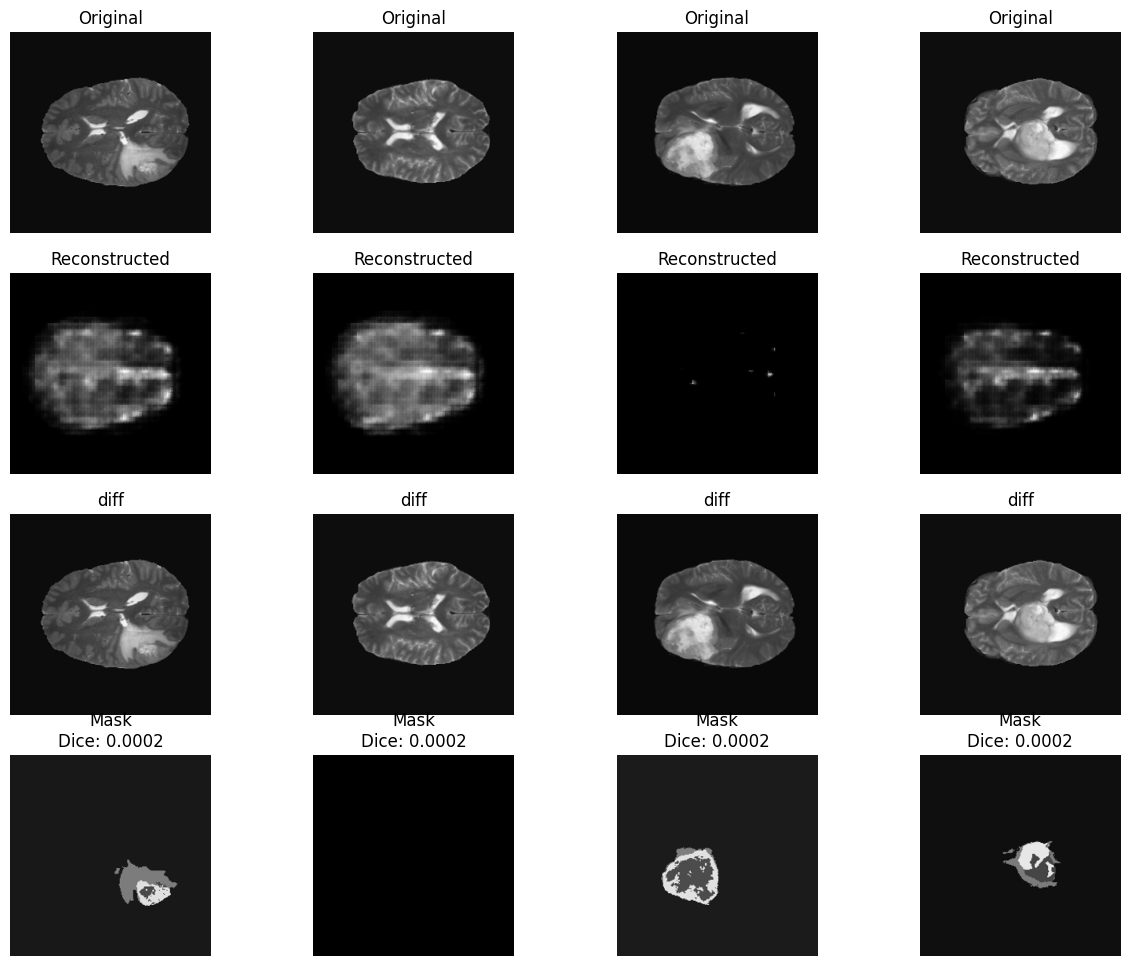

In [458]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def dice_coefficient(pred, target, threshold=0.5):
    smooth = 1.0
    pred_flat = (pred > threshold).float().view(-1)
    target_flat = target.view(-1).float()
    intersection = (pred_flat * target_flat).sum()
    return (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

trivae.eval()
with torch.no_grad():
    # for i, data in enumerate(train_loader):
    for i, (data, mask) in enumerate(test_loader):
        #data, mask = data.to(device), mask.to(device)
        recon_batch, recon2_batch, _, _ = trivae(data.to(device))
        print(recon_batch.shape, recon2_batch.shape)
        fig, axes = plt.subplots(4, data.size(0), figsize=(15, 12))
        dice_scores = []
        for j in range(data.size(0)):
            original_image = data[j].cpu().view(256, 256)

            ########################################
            reconstructed_image = recon_batch[j].cpu().view(256, 256)
            mask_image = mask[j].cpu().view(256, 256)

            # dice_score = dice_coefficient(reconstructed_image, mask_image)
            # dice_scores.append(dice_score.item())

            axes[0, j].imshow(original_image, cmap='gray')
            axes[0, j].set_title('Original')
            axes[0, j].axis('off')

            axes[1, j].imshow(reconstructed_image, cmap='gray')
            axes[1, j].set_title('Reconstructed')
            axes[1, j].axis('off')

            axes[2, j].imshow(original_image-reconstructed_image, cmap='gray')
            axes[2, j].set_title('diff')
            axes[2, j].axis('off')

            axes[3, j].imshow(mask_image, cmap='gray')
            axes[3, j].set_title(f'Mask\nDice: {dice_score:.4f}')
            axes[3, j].axis('off')

        # avg_dice = sum(dice_scores) / len(dice_scores)
        # print(f"Avg Dice: {avg_dice:.4f}")

        plt.show()
        break